# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: XCeption
- Fractal module used: with Percolation 
- Number of layers tuned: 3

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['conv2d_3', 'block14_sepconv1','block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False 
        
        self.f_model = tf.keras.applications.xception.Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['conv2d_3', 'block14_sepconv1','block14_sepconv2']:
                layer.trainable = True
            else:
                layer.trainable = False   
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.2197 - accuracy: 0.6670
Epoch 1: val_loss improved from inf to 1.21476, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6738s 7s/step - loss: 1.2197 - accuracy: 0.6670 - val_loss: 1.2148 - val_accuracy: 0.6654
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.2012 - accuracy: 0.6683
Epoch 2: val_loss improved from 1.21476 to 1.21262, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7630s 8s/step - loss: 1.2012 - accuracy: 0.6683 - val_loss: 1.2126 - val_accuracy: 0.6654
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.6683
Epoch 3: val_loss did not improve from 1.21262
947/947 [==============================] - 7102s 8s/step - loss: 1.1998 - accuracy: 0.6683 - val_loss: 1.2143 - val_accuracy: 0.6654
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6682
Epoch 4: val_loss improved from 1.21262 to 1.21117, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8095s 9s/step - loss: 1.1981 - accuracy: 0.6682 - val_loss: 1.2112 - val_accuracy: 0.6654
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.1875 - accuracy: 0.6680
Epoch 5: val_loss improved from 1.21117 to 1.17903, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7827s 8s/step - loss: 1.1875 - accuracy: 0.6680 - val_loss: 1.1790 - val_accuracy: 0.6654
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.6687
Epoch 6: val_loss improved from 1.17903 to 1.17037, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8180s 9s/step - loss: 1.1598 - accuracy: 0.6687 - val_loss: 1.1704 - val_accuracy: 0.6657
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.1480 - accuracy: 0.6727
Epoch 7: val_loss improved from 1.17037 to 1.16164, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8691s 9s/step - loss: 1.1480 - accuracy: 0.6727 - val_loss: 1.1616 - val_accuracy: 0.6712
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.1396 - accuracy: 0.6731
Epoch 8: val_loss did not improve from 1.16164
947/947 [==============================] - 10055s 11s/step - loss: 1.1396 - accuracy: 0.6731 - val_loss: 1.1617 - val_accuracy: 0.6702
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.1306 - accuracy: 0.6747
Epoch 9: val_loss improved from 1.16164 to 1.14155, saving model to checkpoints/model.ckpt


947/947 [==============================] - 10091s 11s/step - loss: 1.1306 - accuracy: 0.6747 - val_loss: 1.1416 - val_accuracy: 0.6732
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.1205 - accuracy: 0.6763
Epoch 10: val_loss improved from 1.14155 to 1.12494, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9542s 10s/step - loss: 1.1205 - accuracy: 0.6763 - val_loss: 1.1249 - val_accuracy: 0.6739
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.1046 - accuracy: 0.6786
Epoch 11: val_loss improved from 1.12494 to 1.10220, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8492s 9s/step - loss: 1.1046 - accuracy: 0.6786 - val_loss: 1.1022 - val_accuracy: 0.6790
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.6787
Epoch 12: val_loss improved from 1.10220 to 1.09462, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7926s 8s/step - loss: 1.0932 - accuracy: 0.6787 - val_loss: 1.0946 - val_accuracy: 0.6732
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 1.0771 - accuracy: 0.6829
Epoch 13: val_loss did not improve from 1.09462
947/947 [==============================] - 6619s 7s/step - loss: 1.0771 - accuracy: 0.6829 - val_loss: 1.1081 - val_accuracy: 0.6728
Epoch 14/30
947/947 [==============================] - ETA: 0s - loss: 1.0702 - accuracy: 0.6834
Epoch 14: val_loss improved from 1.09462 to 1.05952, saving model to checkpoints/model.ckpt


947/947 [==============================] - 5919s 6s/step - loss: 1.0702 - accuracy: 0.6834 - val_loss: 1.0595 - val_accuracy: 0.6831
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.6855
Epoch 15: val_loss did not improve from 1.05952
947/947 [==============================] - 5531s 6s/step - loss: 1.0575 - accuracy: 0.6855 - val_loss: 1.1503 - val_accuracy: 0.6767
Epoch 16/30
947/947 [==============================] - ETA: 0s - loss: 1.0503 - accuracy: 0.6844
Epoch 16: val_loss improved from 1.05952 to 1.05427, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6041s 6s/step - loss: 1.0503 - accuracy: 0.6844 - val_loss: 1.0543 - val_accuracy: 0.6814
Epoch 17/30
947/947 [==============================] - ETA: 0s - loss: 1.0475 - accuracy: 0.6860
Epoch 17: val_loss improved from 1.05427 to 1.04723, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9300s 10s/step - loss: 1.0475 - accuracy: 0.6860 - val_loss: 1.0472 - val_accuracy: 0.6815
Epoch 18/30
947/947 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.6893 
Epoch 18: val_loss improved from 1.04723 to 1.01745, saving model to checkpoints/model.ckpt


947/947 [==============================] - 12235s 13s/step - loss: 1.0303 - accuracy: 0.6893 - val_loss: 1.0174 - val_accuracy: 0.6845
Epoch 19/30
947/947 [==============================] - ETA: 0s - loss: 1.0350 - accuracy: 0.6883
Epoch 19: val_loss improved from 1.01745 to 1.01197, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7876s 8s/step - loss: 1.0350 - accuracy: 0.6883 - val_loss: 1.0120 - val_accuracy: 0.6880
Epoch 20/30
947/947 [==============================] - ETA: 0s - loss: 1.0281 - accuracy: 0.6879
Epoch 20: val_loss improved from 1.01197 to 1.01137, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7258s 8s/step - loss: 1.0281 - accuracy: 0.6879 - val_loss: 1.0114 - val_accuracy: 0.6896
Epoch 21/30
947/947 [==============================] - ETA: 0s - loss: 1.0219 - accuracy: 0.6907
Epoch 21: val_loss did not improve from 1.01137
947/947 [==============================] - 7993s 8s/step - loss: 1.0219 - accuracy: 0.6907 - val_loss: 1.0318 - val_accuracy: 0.6866
Epoch 22/30
947/947 [==============================] - ETA: 0s - loss: 1.0078 - accuracy: 0.6933
Epoch 22: val_loss did not improve from 1.01137
947/947 [==============================] - 8005s 8s/step - loss: 1.0078 - accuracy: 0.6933 - val_loss: 1.0692 - val_accuracy: 0.6880
Epoch 23/30
947/947 [==============================] - ETA: 0s - loss: 1.0010 - accuracy: 0.6936
Epoch 23: val_loss did not improve from 1.01137
947/947 [==============================] - 7869s 8s/step - loss: 1.0010 - accuracy: 0.6936 - val_loss: 1.1089 - val_accuracy: 0.6825


### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 507s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.8524755662997747,
 'basal cell carcinoma': 0.793764838666027,
 'dermatofibroma': 0.743595107179855,
 'melanoma': 0.7500056152014736,
 'nevus': 0.8289151843359879,
 'pigmented benign keratosis': 0.7713125961740412,
 'seborrheic keratosis': 0.6737120088954782,
 'solar lentigo': 0.7835868005738881,
 'squamous cell carcinoma': 0.7956612734444176,
 'vascular lesion': 0.6492947645230696}

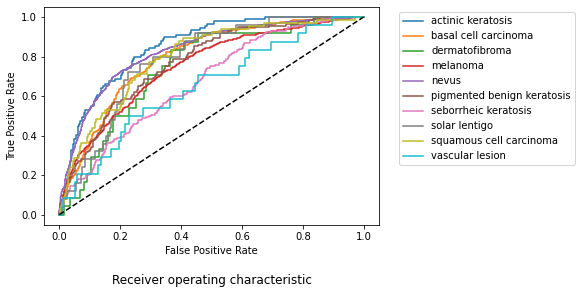

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

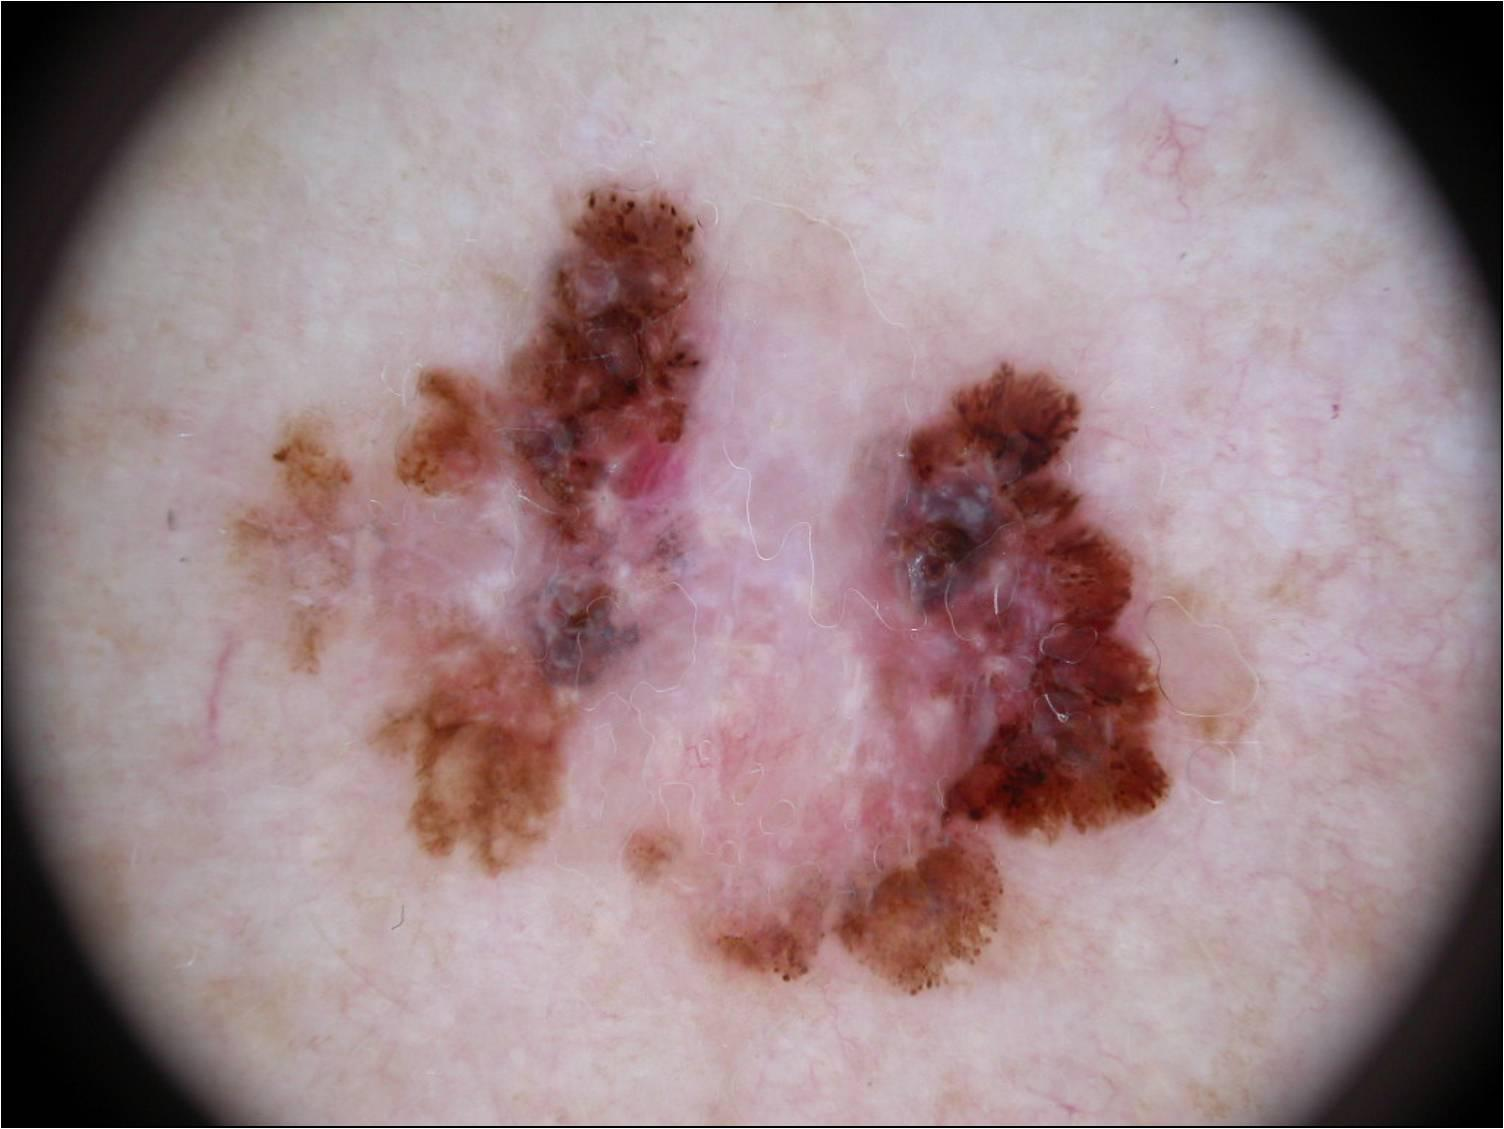

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.xception.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'block14_sepconv2')

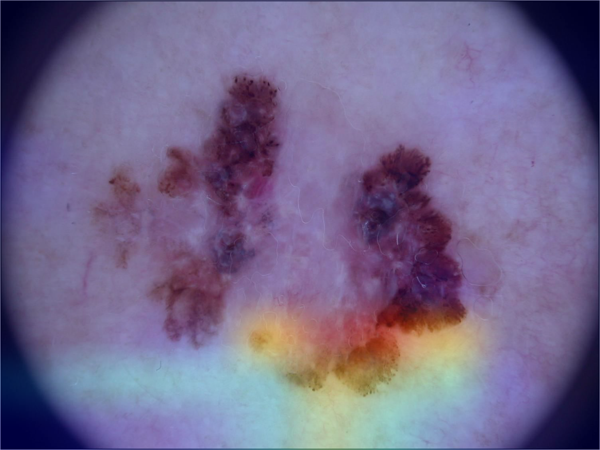

In [21]:
display_gradcam(melanoma_im_path, heatmap)